In [1]:
from Funcs.Utility import *

In [2]:
p = os.path.join(PATH_INTERMEDIATE, 'stress_binary_personal-15min.pkl')
X, y, groups, t, datetimes = load(p)

In [3]:
#Divide the features into different categories
feat_current = X.loc[:,[('#VAL' in str(x)) or ('ESM#LastLabel' in str(x)) for x in X.keys()]]  
feat_dsc = X.loc[:,[('#DSC' in str(x))  for x in X.keys()]]  
feat_yesterday = X.loc[:,[('Yesterday' in str(x))  for x in X.keys()]]  
feat_today = X.loc[:,[('Today' in str(x))  for x in X.keys()]]  
feat_sleep = X.loc[:,[('Sleep' in str(x))  for x in X.keys()]]  
feat_time = X.loc[:,[('Time' in str(x))  for x in X.keys()]]  
feat_pif = X.loc[:,[('PIF' in str(x))  for x in X.keys()]]  
feat_ImmediatePast = X.loc[:,[('ImmediatePast_15' in str(x))  for x in X.keys()]]
#Divide the time window features into sensor/past stress label
feat_current_sensor = X.loc[:,[('#VAL' in str(x))  for x in X.keys()]]  
feat_current_ESM = X.loc[:,[('ESM#LastLabel' in str(x)) for x in X.keys()]]  
feat_ImmediatePast_sensor = feat_ImmediatePast.loc[:,[('ESM' not in str(x)) for x in feat_ImmediatePast.keys()]]  
feat_ImmediatePast_ESM = feat_ImmediatePast.loc[:,[('ESM'  in str(x)) for x in feat_ImmediatePast.keys()]]  
feat_today_sensor = feat_today.loc[:,[('ESM' not in str(x))  for x in feat_today.keys()]]  
feat_today_ESM = feat_today.loc[:,[('ESM'  in str(x)) for x in feat_today.keys()]]  
feat_yesterday_sensor = feat_yesterday.loc[:,[('ESM' not in str(x)) for x in feat_yesterday.keys()]]  
feat_yesterday_ESM = feat_yesterday.loc[:,[('ESM'  in str(x)) for x in feat_yesterday.keys()]]

In [4]:
feat_baseline = pd.concat([ feat_time,feat_dsc,feat_current_sensor, feat_ImmediatePast_sensor],axis=1)
feat_final = pd.concat([feat_baseline  ], axis=1)
# # Fill NaN values with zeros
feat_final = feat_final.fillna(0)
X = feat_final
cats = X.columns[X.dtypes == bool]

In [5]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, classification_report

In [6]:
from sklearn.metrics import roc_auc_score
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
import xgboost as xgb

logo = LeaveOneGroupOut()
# To store the AUC for each user
user_auc_scores = []

for train_index, test_index in logo.split(X, y, groups=groups):
    # Splitting the data based on user groups
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]  # Use iloc for row indexing
    y_train, y_test = y[train_index], y[test_index]
    group_test = groups[test_index]  # Groups of test data

    # Create DMatrix for XGBoost
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    # Set up the XGBoost model
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'eta': 0.1,
        'max_depth': 6,
        'seed': 42
    }

    # Train the model
    model = xgb.train(params, dtrain, num_boost_round=100)

    # Make predictions
    y_pred = model.predict(dtest)

    # Calculate AUC
    try:
        auc = roc_auc_score(y_test, y_pred)
        print(f"User {group_test[0]} AUC: {auc}")
    except ValueError:
        # Handle case where only one class is present in y_test (cannot calculate AUC)
        auc = 0
        print(f"User {group_test[0]} AUC: Unable to calculate AUC due to single class in y_test")

    # Store the PID and its AUC score
    user_auc_scores.append((group_test[0], auc))

# Convert the results into a DataFrame to make sorting easier
user_auc_df = pd.DataFrame(user_auc_scores, columns=['PID', 'AUC'])

# IQR Method to find outliers
Q1 = user_auc_df['AUC'].quantile(0.25)
Q3 = user_auc_df['AUC'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower bound for outliers
lower_bound = Q1 - 1.5 * IQR

# Identify users with AUCs below the lower bound
lowest_performing_users = user_auc_df[user_auc_df['AUC'] < lower_bound]

# Display the lowest-performing users
print("Lowest performing users based on IQR method:")
print(lowest_performing_users) 

User P001 AUC: 0.4900634249471459
User P002 AUC: 0.531193674050817
User P003 AUC: 0.5239018087855298
User P007 AUC: 0.4666034555415086
User P008 AUC: 0.5322634200332043
User P009 AUC: 0.5861423220973783
User P010 AUC: 0.5594607607125662
User P011 AUC: 0.5997174143412223
User P013 AUC: 0.5046831955922866
User P014 AUC: 0.49658746208291205
User P015 AUC: 0.5646205646205646
User P016 AUC: 0.5518950437317783
User P018 AUC: 0.4412863886703383
User P019 AUC: 0.5825551782682513
User P020 AUC: 0.5904451549434334
User P021 AUC: 0.6423588578844905
User P022 AUC: 0.4418049270990448
User P023 AUC: 0.6624978287302414
User P024 AUC: 0.4662220309810672
User P025 AUC: 0.6130542307012895
User P026 AUC: 0.659634317862166
User P027 AUC: 0.5353896103896104
User P028 AUC: 0.6203714253161672
User P029 AUC: 0.5606153846153846
User P030 AUC: 0.46274323682961555
User P033 AUC: 0.5615887380593263
User P034 AUC: 0.5008012820512822
User P035 AUC: 0.6173639226270805
User P037 AUC: 0.5004281345565749
User P038 AUC:

In [28]:
# Define the lower bound for outliers
lower_bound = Q1 - 0.5 * IQR

# Identify users with AUCs below the lower bound
lowest_performing_users = user_auc_df[user_auc_df['AUC'] < lower_bound]

# Display the lowest-performing users
print("Lowest performing users based on IQR method:")
print(lowest_performing_users) 

Lowest performing users based on IQR method:
      PID       AUC
12   P018  0.441286
16   P022  0.441805
56   P071  0.409814
95   P120  0.445958
103  P131  0.424382


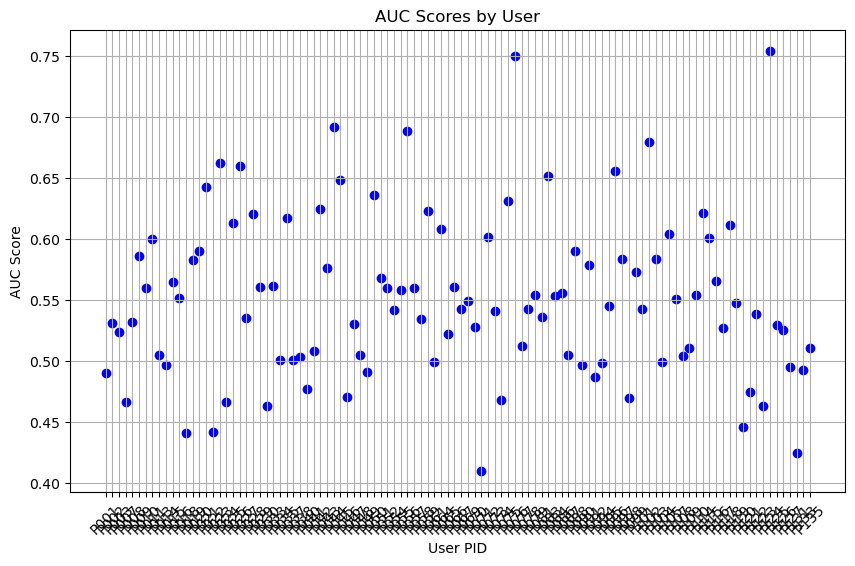

In [29]:
import matplotlib.pyplot as plt

pids, auc_scores = zip(*user_auc_scores)
plt.figure(figsize=(10, 6))
plt.scatter(pids, auc_scores, color='blue')

# Add labels and title
plt.xlabel('User PID')
plt.ylabel('AUC Score')
plt.title('AUC Scores by User')

# Optionally, add a grid for better readability
plt.grid(True)

# Show the plot
plt.xticks(rotation=45)  
plt.show()

In [30]:
import pandas as pd

# Assuming X is your DataFrame

# List of prefixes to filter
prefixes = ['SCR', 'PWR', 'CHG', 'BAT', 'LOC']

# Filter columns based on the prefixes
filtered_columns = [col for col in X.columns if any(col.startswith(prefix) for prefix in prefixes)]

# Create a new DataFrame with the filtered columns
filtered_df = X[filtered_columns]

X_fil = filtered_df

In [31]:
X_fil = X_fil[[col for col in X_fil.columns if not col.endswith('#ImmediatePast_15')]]

In [32]:
cn = X_fil.columns.tolist()
print(cn)

['BAT_STA#DSC', 'BAT_STA#DSC=DISCHARGINGCHARGINGFULLNOT_CHARGING', 'BAT_PLG#DSC', 'BAT_PLG#DSC=UNDEFINEDACUSBWIRELESS', 'LOC_LABEL#DSC', 'LOC_LABEL#DSC=noneworkhome', 'SCR_EVENT#DSC', 'SCR_EVENT#DSC=SCREEN_OFFSCREEN_ONUSER_PRESENT', 'CHG#DSC', 'CHG#DSC=DISCONNECTED', 'CHG#DSC=CONNECTED', 'PWR#DSC', 'PWR#DSC=ACTIVATE', 'PWR#DSC=DEACTIVATE', 'BAT_LEV#VAL', 'BAT_STA#VAL=DISCHARGINGCHARGINGFULLNOT_CHARGING', 'BAT_TMP#VAL', 'BAT_PLG#VAL=UNDEFINEDACUSBWIRELESS', 'LOC_LABEL#VAL=noneworkhome', 'SCR_EVENT#VAL=SCREEN_OFFSCREEN_ONUSER_PRESENT', 'SCR_DUR#VAL', 'CHG#VAL=DISCONNECTED', 'CHG#VAL=CONNECTED', 'PWR#VAL=ACTIVATE', 'PWR#VAL=DEACTIVATE']


In [33]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming the sorted_user_auc_df contains the sorted PIDs with their AUC
# lowest_performing_pids = sorted_user_auc_df['PID'].head(5).values

# # Create a DataFrame for the low-performing and high-performing users using the groups array
# X_low = X[np.isin(groups, lowest_performing_pids)]
# X_high = X[~np.isin(groups, lowest_performing_pids)]

# # Function to compare trends for each feature
# def analyze_feature_trends(cn, X_low, X_high):
#     for feature in cn:
#         print(f"\nAnalyzing Feature: {feature}")
        
#         # Check if the feature is in X
#         if feature not in X.columns:
#             print(f"Feature {feature} not found in dataset!")
#             continue
        
#         # Separate the feature values for low and high-performing users
#         low_vals = X_low[feature]
#         high_vals = X_high[feature]

#         # If the feature is numeric, compare means
#         if np.issubdtype(low_vals.dtype, np.number):
#             low_mean = low_vals.mean()
#             high_mean = high_vals.mean()
#             print(f"Low-performing Mean: {low_mean}, High-performing Mean: {high_mean}")
            
#             # Plot the distribution for both
#             plt.figure(figsize=(10, 6))
#             plt.hist(low_vals, bins=30, alpha=0.5, label='Low-performing', color='red')
#             plt.hist(high_vals, bins=30, alpha=0.5, label='High-performing', color='blue')
#             plt.title(f'Distribution of {feature}')
#             plt.legend()
#             plt.show()
        
#         # If the feature is categorical, compare value counts
#         else:
#             low_counts = low_vals.value_counts(normalize=True)
#             high_counts = high_vals.value_counts(normalize=True)
#             comparison = pd.DataFrame({'Low-performing': low_counts, 'High-performing': high_counts}).fillna(0)
#             print(comparison)
            
#             # Plot the comparison
#             comparison.plot(kind='bar', figsize=(10, 6), title=f'{feature} Comparison')
#             plt.show()

# # Apply the analysis to the feature list
# analyze_feature_trends(cn, X_low, X_high)


In [34]:
!pip install slicer

correlation

Training XGBoost for low-performing users...
Training XGBoost for high-performing users...
Feature Importance Comparison between Low and High Performing Users using SHAP:
                                Feature  Importance_low  Importance_high  \
47                              PWR#DSC        0.484490         0.065654   
29                             RING#DSC        0.266927         0.045246   
40                         Dozemode#DSC        0.243917         0.033632   
109        BAT_TMP#MED#ImmediatePast_15        0.159182         0.016991   
196        SCR_DUR#STD#ImmediatePast_15        0.133640         0.008454   
..                                  ...             ...              ...   
215  BT_classType#ETP##ImmediatePast_15        0.026161         0.045879   
149      DATA_MSNT#AVG#ImmediatePast_15        0.004619         0.025173   
103        BAT_TMP#AVG#ImmediatePast_15        0.039086         0.068854   
13              Time#HRN=LATE_AFTERNOON        0.001559         0.040

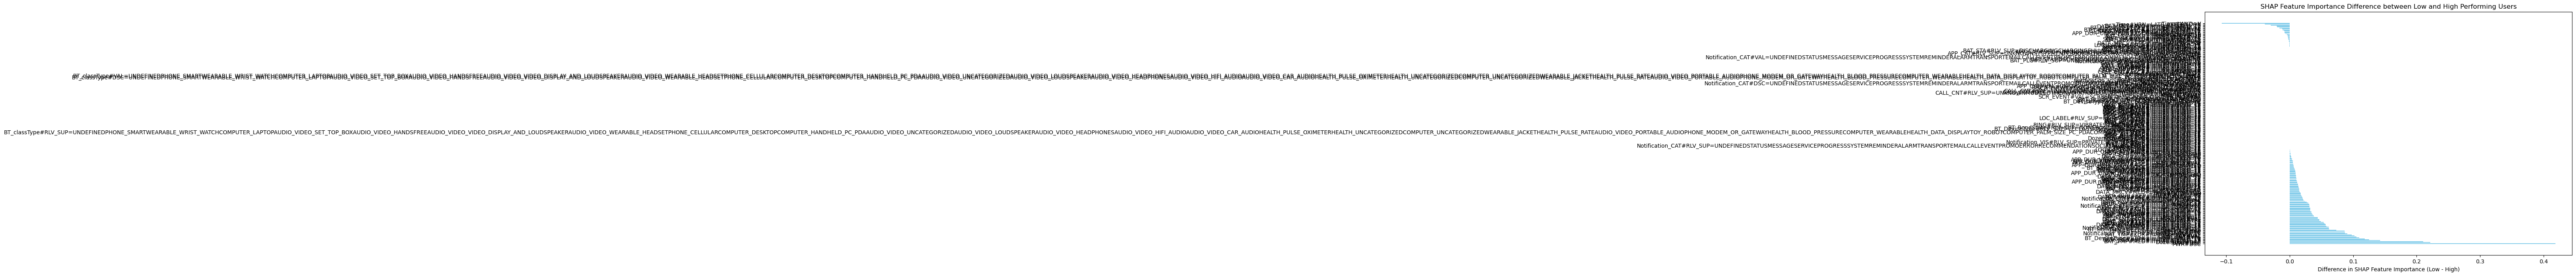

In [35]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

# Assuming the sorted_user_auc_df contains the sorted PIDs with their AUC
lowest_performing_pids = lowest_performing_users['PID']

# Create a DataFrame for the low-performing and high-performing users using the groups array
X_low = X[np.isin(groups, lowest_performing_pids)]
X_high = X[~np.isin(groups, lowest_performing_pids)]

y_low = y[np.isin(groups, lowest_performing_pids)]
y_high = y[~np.isin(groups, lowest_performing_pids)]

# Create DMatrix for low and high-performing users
dtrain_low = xgb.DMatrix(X_low, label=y_low)
dtrain_high = xgb.DMatrix(X_high, label=y_high)

# Set up common XGBoost parameters
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'eta': 0.1,
    'max_depth': 6
}

# Train the model for low-performing users
print("Training XGBoost for low-performing users...")
model_low = xgb.train(params, dtrain_low, num_boost_round=100)

# Train the model for high-performing users
print("Training XGBoost for high-performing users...")
model_high = xgb.train(params, dtrain_high, num_boost_round=100)

# Initialize the SHAP explainer for both models
explainer_low = shap.TreeExplainer(model_low)
explainer_high = shap.TreeExplainer(model_high)

# Calculate SHAP values for the features in both low and high-performing groups
shap_values_low = explainer_low.shap_values(X_low)
shap_values_high = explainer_high.shap_values(X_high)

# Calculate mean absolute SHAP values for each feature to get the feature importance
importance_low = np.abs(shap_values_low).mean(axis=0)
importance_high = np.abs(shap_values_high).mean(axis=0)

# Convert the SHAP values into a DataFrame for easy comparison
features = X_low.columns  # Assuming X_low and X_high have the same columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance_low': importance_low,
    'Importance_high': importance_high
})

# Calculate the difference in importance between low and high-performing users
importance_df['Importance_diff'] = importance_df['Importance_low'] - importance_df['Importance_high']

# Sort by the difference in importance
importance_df = importance_df.sort_values(by='Importance_diff', ascending=False)

# Display the top features that differ the most
print("Feature Importance Comparison between Low and High Performing Users using SHAP:")
print(importance_df)

# Plot the feature importance comparison using SHAP values
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance_diff'], color='skyblue')
plt.xlabel('Difference in SHAP Feature Importance (Low - High)')
plt.title('SHAP Feature Importance Difference between Low and High Performing Users')
plt.show()


In [36]:
# import pandas as pd
# import numpy as np
# import xgboost as xgb
# import matplotlib.pyplot as plt

# # Assuming the sorted_user_auc_df contains the sorted PIDs with their AUC
# lowest_performing_pids = sorted_user_auc_df['PID'].head(5).values

# # Create a DataFrame for the low-performing and high-performing users using the groups array
# X_low = X[np.isin(groups, lowest_performing_pids)]
# X_high = X[~np.isin(groups, lowest_performing_pids)]

# y_low = y[np.isin(groups, lowest_performing_pids)]
# y_high = y[~np.isin(groups, lowest_performing_pids)]

# # Create DMatrix for low and high-performing users
# dtrain_low = xgb.DMatrix(X_low, label=y_low)
# dtrain_high = xgb.DMatrix(X_high, label=y_high)

# # Set up common XGBoost parameters
# params = {
#     'objective': 'binary:logistic',
#     'eval_metric': 'logloss',
#     'eta': 0.1,
#     'max_depth': 6
# }

# # Train the model for low-performing users
# print("Training XGBoost for low-performing users...")
# model_low = xgb.train(params, dtrain_low, num_boost_round=100)

# # Train the model for high-performing users
# print("Training XGBoost for high-performing users...")
# model_high = xgb.train(params, dtrain_high, num_boost_round=100)

# # Get feature importance for both models
# importance_low = model_low.get_score(importance_type='weight')
# importance_high = model_high.get_score(importance_type='weight')

# # Convert the feature importance into a DataFrame for easy comparison
# importance_df_low = pd.DataFrame(list(importance_low.items()), columns=['Feature', 'Importance_low'])
# importance_df_high = pd.DataFrame(list(importance_high.items()), columns=['Feature', 'Importance_high'])

# # Merge both importance DataFrames to compare
# importance_df = pd.merge(importance_df_low, importance_df_high, on='Feature', how='outer').fillna(0)

# # Sort by the difference in importance
# importance_df['Importance_diff'] = importance_df['Importance_low'] - importance_df['Importance_high']
# importance_df = importance_df.sort_values(by='Importance_diff', ascending=False)

# # Display the top features that differ the most
# print("Feature Importance Comparison between Low and High Performing Users:")
# print(importance_df)

# # Plot the feature importance comparison
# plt.figure(figsize=(12, 8))
# plt.barh(importance_df['Feature'], importance_df['Importance_diff'], color='skyblue')
# plt.xlabel('Difference in Feature Importance (Low - High)')
# plt.title('Feature Importance Difference between Low and High Performing Users')
# plt.show()

In [37]:
importance_df = importance_df.sort_values(by='Importance_diff', ascending=True)
importance_df

,Feature,Importance_low,Importance_high,Importance_diff
8,Time#WKD=Y,0.002888,0.110039,-0.107152
13,Time#HRN=LATE_AFTERNOON,0.001559,0.040776,-0.039217
103,BAT_TMP#AVG#ImmediatePast_15,0.039086,0.068854,-0.029768
149,DATA_MSNT#AVG#ImmediatePast_15,0.004619,0.025173,-0.020554
215,BT_classType#ETP##ImmediatePast_15,0.026161,0.045879,-0.019718
...,...,...,...,...
196,SCR_DUR#STD#ImmediatePast_15,0.133640,0.008454,0.125186
109,BAT_TMP#MED#ImmediatePast_15,0.159182,0.016991,0.142191
40,Dozemode#DSC,0.243917,0.033632,0.210285
29,RING#DSC,0.266927,0.045246,0.221681


Descriptive Statistics for Low Performing Users:
Mean: 30.672590255737305, Median: 30.899999618530273, Std: 4.441868782043457, Min: 12.100000381469727, Max: 42.0

Descriptive Statistics for High Performing Users:
Mean: 30.216835021972656, Median: 30.200000762939453, Std: 4.667820930480957, Min: 4.0, Max: 48.599998474121094


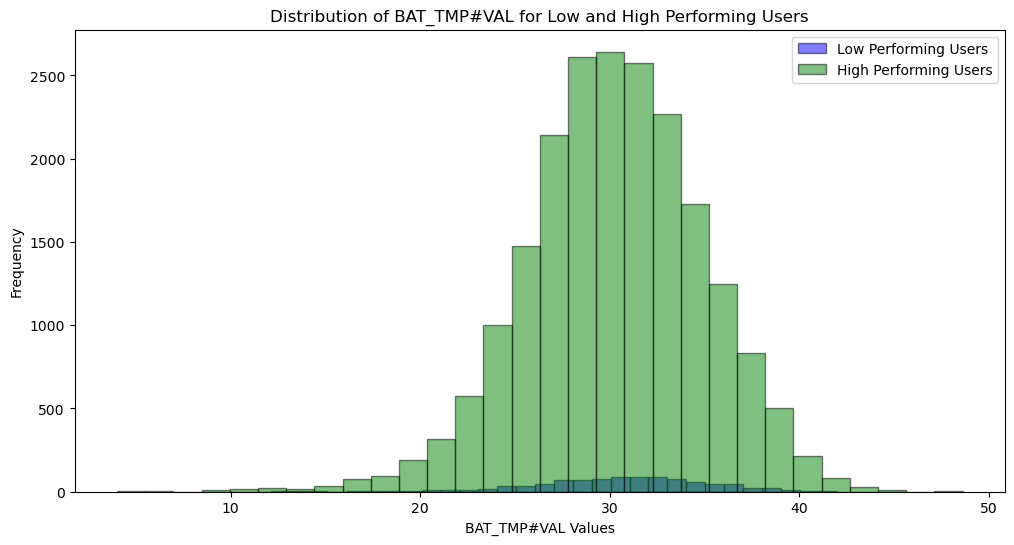

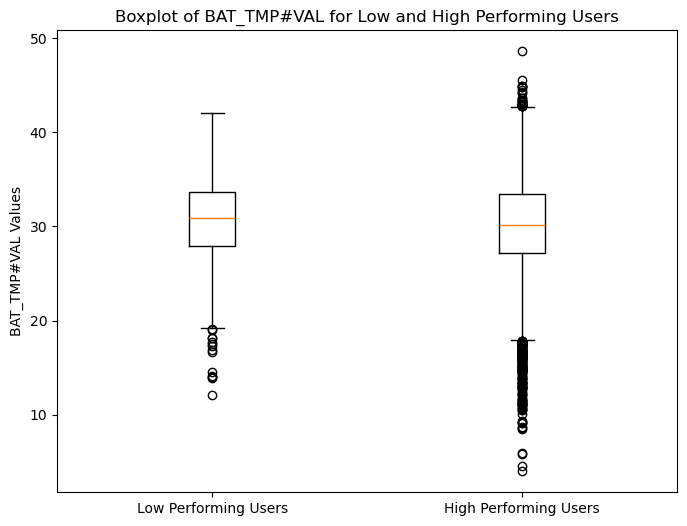

T-test results for BAT_TMP#VAL: t-statistic = 3.041602147579421, p-value = 0.002413684892122855
Mann-Whitney U test results for BAT_TMP#VAL: U-statistic = 10204536.5, p-value = 0.0004286558276775095
Pearson correlation for low-performing users: -0.09151535461669047
Pearson correlation for high-performing users: 0.07473809085775729


In [38]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'BAT_TMP#VAL'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


Descriptive Statistics for Low Performing Users:
Mean: 43908476.0, Median: 19907.259765625, Std: 618732928.0, Min: 0.0, Max: 17760813056.0

Descriptive Statistics for High Performing Users:
Mean: 20292088.0, Median: 4053.7421875, Std: 219106336.0, Min: 0.0, Max: 12513092608.0


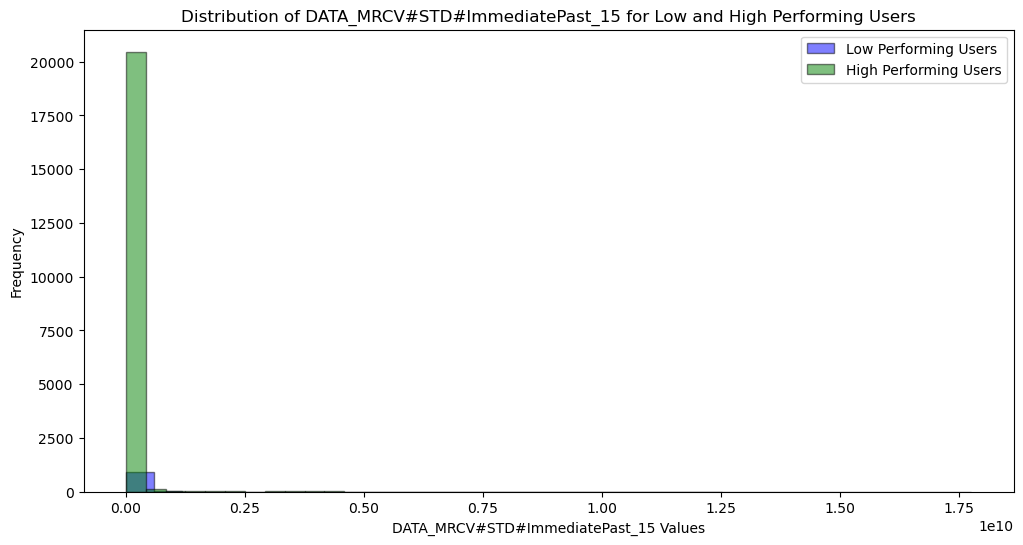

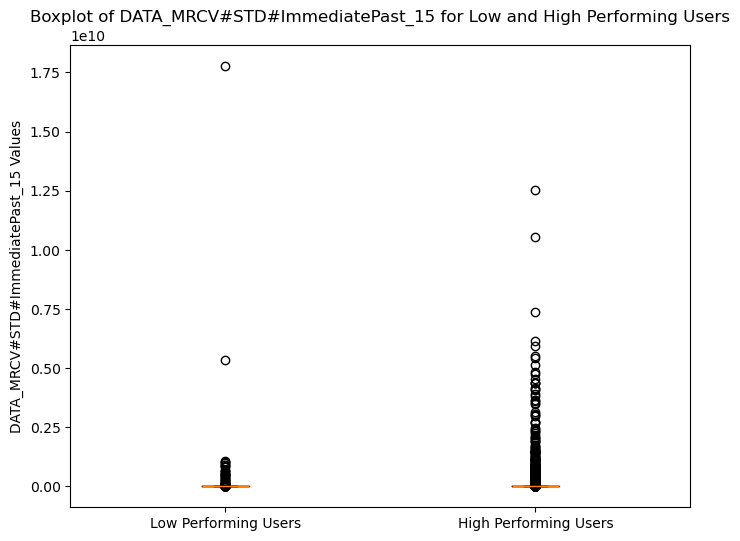

T-test results for DATA_MRCV#STD#ImmediatePast_15: t-statistic = 1.1557627716166665, p-value = 0.24807429585555263
Mann-Whitney U test results for DATA_MRCV#STD#ImmediatePast_15: U-statistic = 9903925.5, p-value = 0.05688433222202502
Pearson correlation for low-performing users: 0.04376708047480151
Pearson correlation for high-performing users: -0.006388560842627965


In [39]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'DATA_MRCV#STD#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


Descriptive Statistics for Low Performing Users:
Mean: 2841584.25, Median: 16394.85546875, Std: 37924780.0, Min: 0.0, Max: 1101061632.0

Descriptive Statistics for High Performing Users:
Mean: 1794421.875, Median: 2237.94873046875, Std: 13353885.0, Min: 0.0, Max: 426565728.0


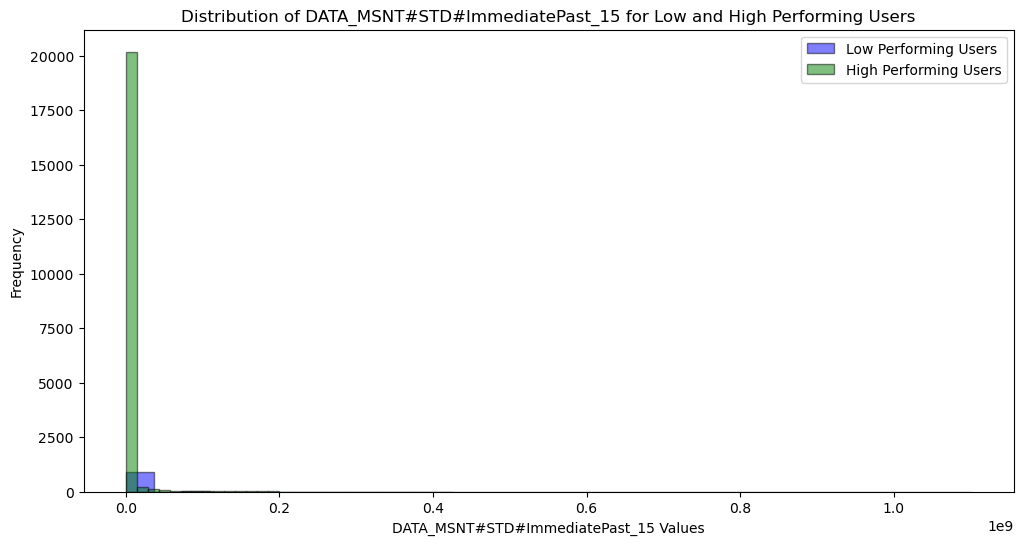

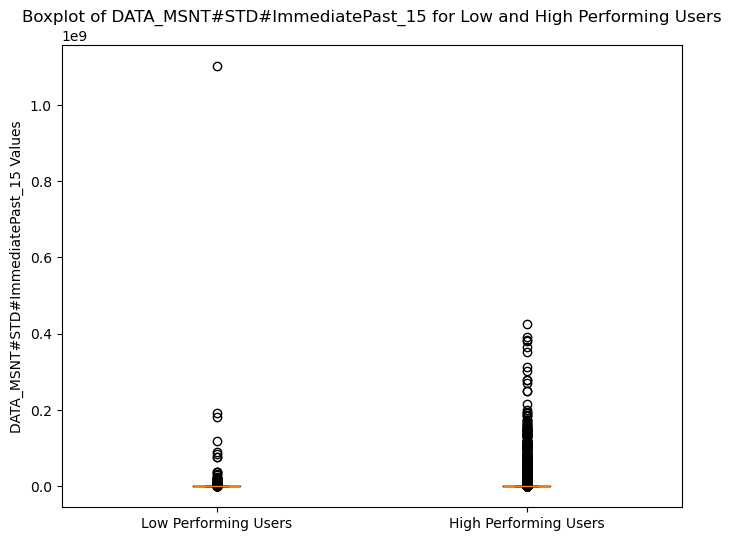

T-test results for DATA_MSNT#STD#ImmediatePast_15: t-statistic = 0.8361084195951671, p-value = 0.403308170022593
Mann-Whitney U test results for DATA_MSNT#STD#ImmediatePast_15: U-statistic = 9891648.0, p-value = 0.06609316822813904
Pearson correlation for low-performing users: 0.03265456001019701
Pearson correlation for high-performing users: -0.016399788068750823


In [40]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'DATA_MSNT#STD#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


In [41]:
importance_df.head(20)

,Feature,Importance_low,Importance_high,Importance_diff
8,Time#WKD=Y,0.002888,0.110039,-0.107152
13,Time#HRN=LATE_AFTERNOON,0.001559,0.040776,-0.039217
103,BAT_TMP#AVG#ImmediatePast_15,0.039086,0.068854,-0.029768
149,DATA_MSNT#AVG#ImmediatePast_15,0.004619,0.025173,-0.020554
215,BT_classType#ETP##ImmediatePast_15,0.026161,0.045879,-0.019718
54,BAT_TMP#VAL,0.025193,0.041456,-0.016263
213,BT_DeviceType#ASC##ImmediatePast_15,0.044982,0.056943,-0.011961
216,BT_classType#ASC##ImmediatePast_15,0.013219,0.024317,-0.011097
150,DATA_MSNT#STD#ImmediatePast_15,0.003299,0.012007,-0.008709
48,PWR#DSC=ACTIVATE,0.011657,0.019926,-0.008269


Descriptive Statistics for Low Performing Users:
Mean: 2.7259573936462402, Median: 2.4884369373321533, Std: 1.6951584815979004, Min: 0.0, Max: 11.241992950439453

Descriptive Statistics for High Performing Users:
Mean: 2.5340285301208496, Median: 2.323251724243164, Std: 1.8124942779541016, Min: 0.0, Max: 18.208240509033203


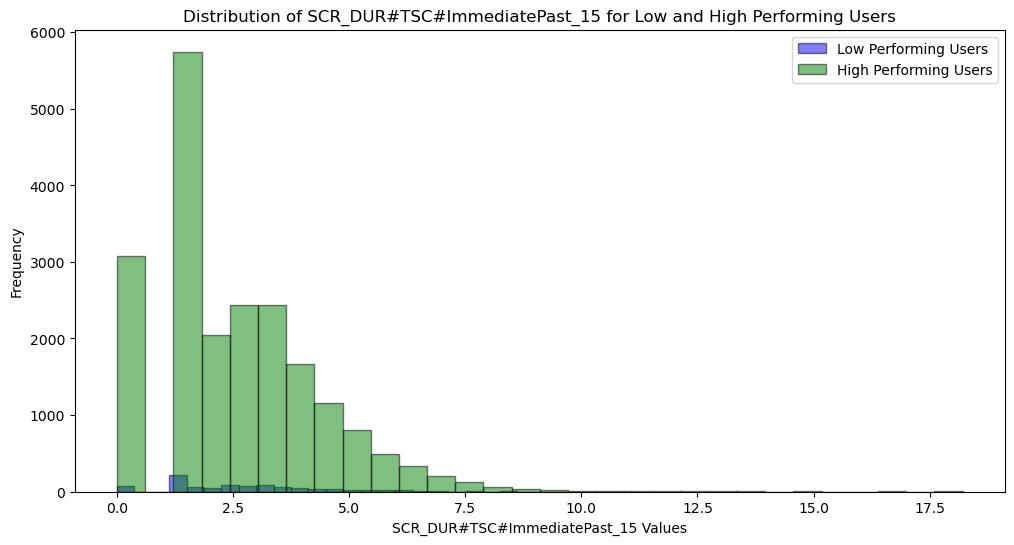

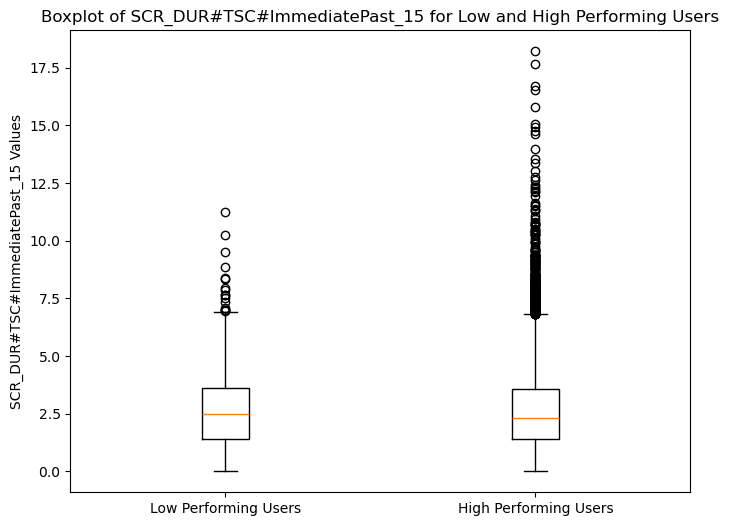

T-test results for SCR_DUR#TSC#ImmediatePast_15: t-statistic = 3.3535776649809557, p-value = 0.0008271324094105588
Mann-Whitney U test results for SCR_DUR#TSC#ImmediatePast_15: U-statistic = 10241589.5, p-value = 0.00019103148674833324
Pearson correlation for low-performing users: 0.0226175005949409
Pearson correlation for high-performing users: -0.01020463545927851


In [42]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'SCR_DUR#TSC#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


Descriptive Statistics for Low Performing Users:
Mean: 43908476.0, Median: 19907.259765625, Std: 618732928.0, Min: 0.0, Max: 17760813056.0

Descriptive Statistics for High Performing Users:
Mean: 20292088.0, Median: 4053.7421875, Std: 219106336.0, Min: 0.0, Max: 12513092608.0


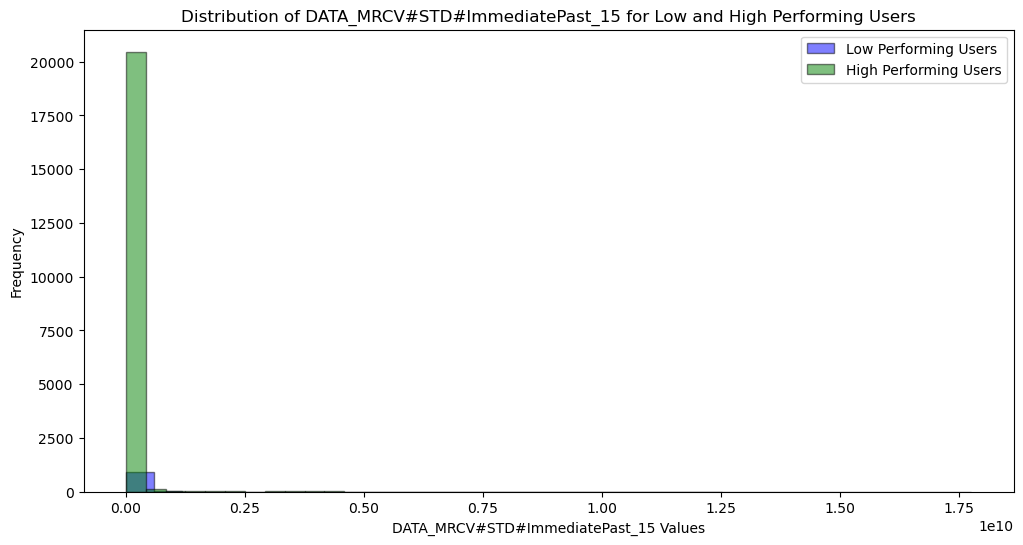

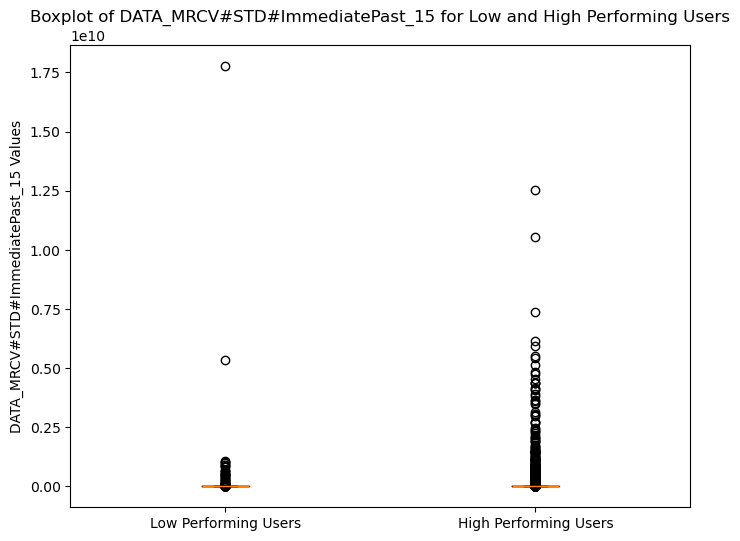

T-test results for DATA_MRCV#STD#ImmediatePast_15: t-statistic = 1.1557627716166665, p-value = 0.24807429585555263
Mann-Whitney U test results for DATA_MRCV#STD#ImmediatePast_15: U-statistic = 9903925.5, p-value = 0.05688433222202502
Pearson correlation for low-performing users: 0.04376708047480151
Pearson correlation for high-performing users: -0.006388560842627965


In [43]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'DATA_MRCV#STD#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


Descriptive Statistics for Low Performing Users:
Mean: 2841584.25, Median: 16394.85546875, Std: 37924780.0, Min: 0.0, Max: 1101061632.0

Descriptive Statistics for High Performing Users:
Mean: 1794421.875, Median: 2237.94873046875, Std: 13353885.0, Min: 0.0, Max: 426565728.0


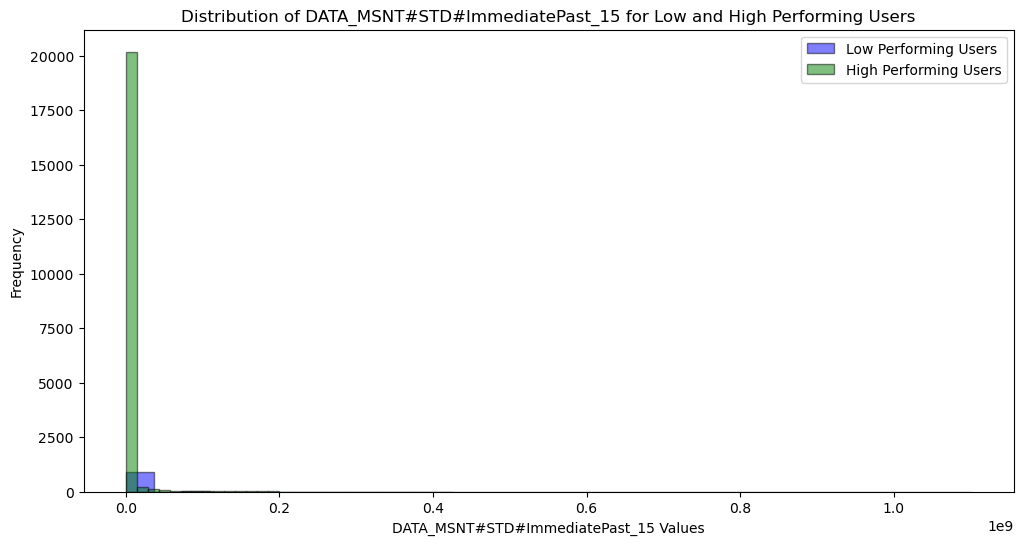

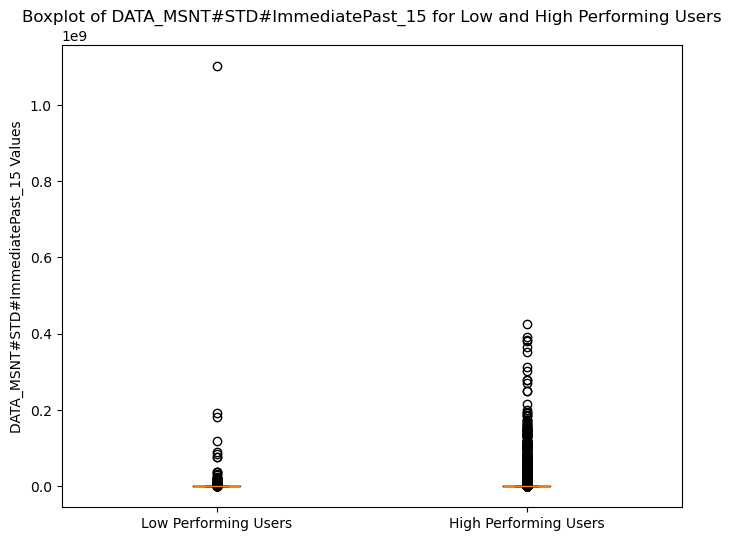

T-test results for DATA_MSNT#STD#ImmediatePast_15: t-statistic = 0.8361084195951671, p-value = 0.403308170022593
Mann-Whitney U test results for DATA_MSNT#STD#ImmediatePast_15: U-statistic = 9891648.0, p-value = 0.06609316822813904
Pearson correlation for low-performing users: 0.03265456001019701
Pearson correlation for high-performing users: -0.016399788068750823


In [44]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'DATA_MSNT#STD#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


Descriptive Statistics for Low Performing Users:
Mean: 30.162458419799805, Median: 30.700000762939453, Std: 5.726895332336426, Min: 0.0, Max: 42.150001525878906

Descriptive Statistics for High Performing Users:
Mean: 29.451780319213867, Median: 30.0, Std: 6.410609722137451, Min: 0.0, Max: 48.79999923706055


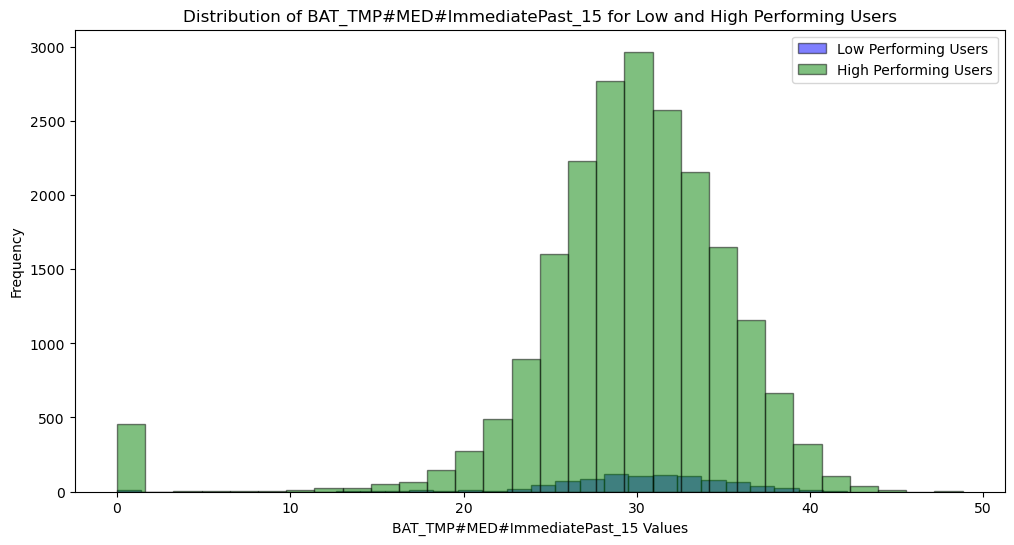

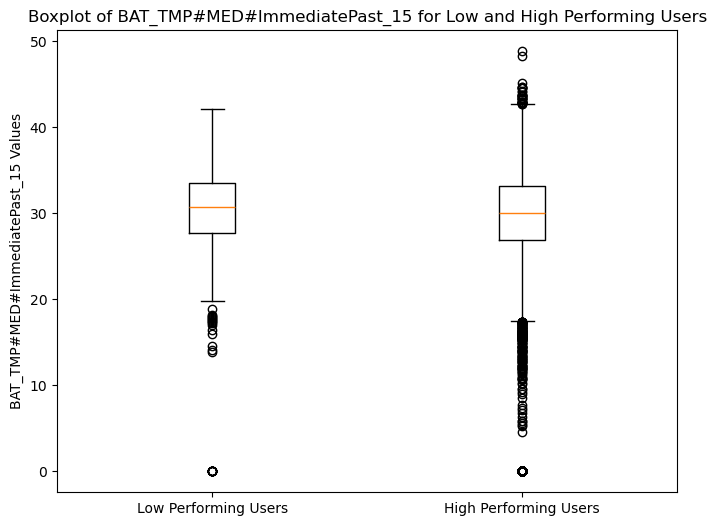

T-test results for BAT_TMP#MED#ImmediatePast_15: t-statistic = 3.6671049917928302, p-value = 0.00025787994987602547
Mann-Whitney U test results for BAT_TMP#MED#ImmediatePast_15: U-statistic = 10223776.0, p-value = 0.00028844352879534176
Pearson correlation for low-performing users: -0.11428627773536394
Pearson correlation for high-performing users: 0.05253542221308118


In [45]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'BAT_TMP#MED#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")


Descriptive Statistics for Low Performing Users:
Mean: 1738.489990234375, Median: 1399.52001953125, Std: 2704.480712890625, Min: 0.0, Max: 42914.546875

Descriptive Statistics for High Performing Users:
Mean: 1600.558837890625, Median: 1366.653564453125, Std: 2112.032958984375, Min: 0.0, Max: 66975.1328125


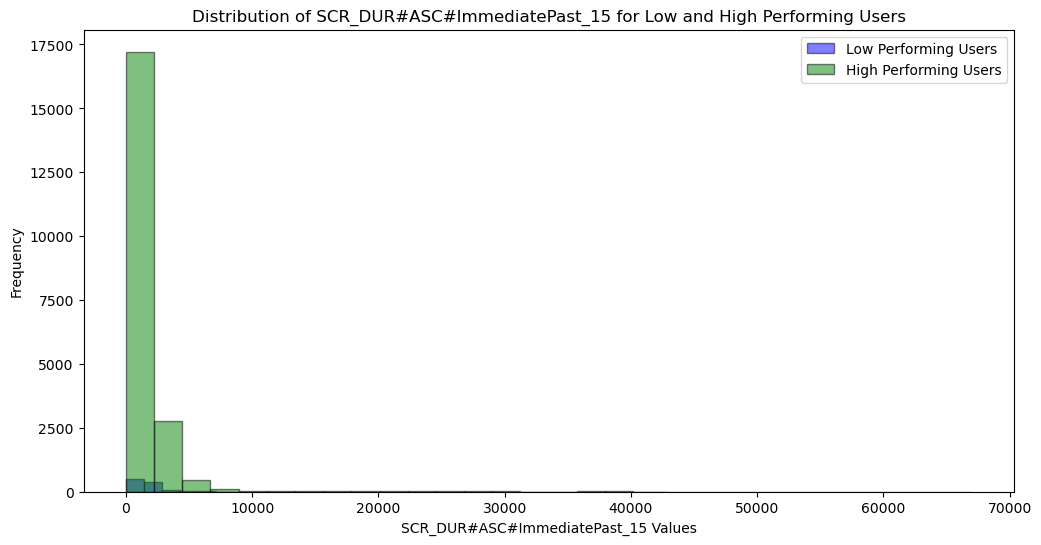

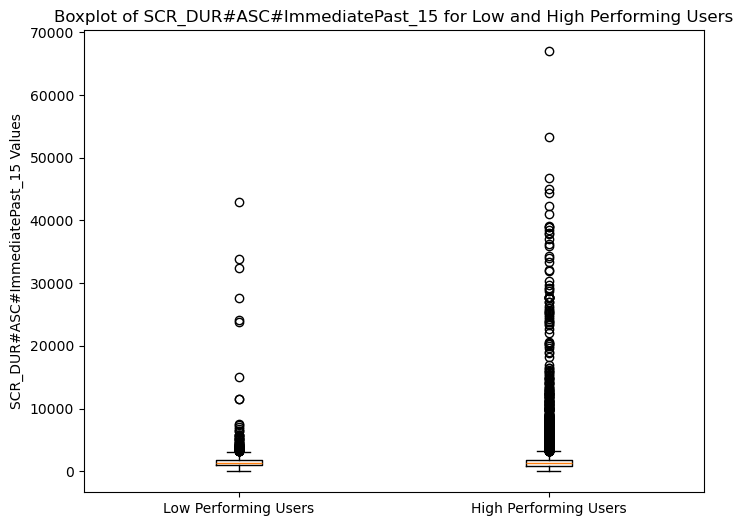

T-test results for SCR_DUR#ASC#ImmediatePast_15: t-statistic = 1.5279964246999045, p-value = 0.12683850944218839
Mann-Whitney U test results for SCR_DUR#ASC#ImmediatePast_15: U-statistic = 9884329.5, p-value = 0.072105932931595
Pearson correlation for low-performing users: -0.051760688504723165
Pearson correlation for high-performing users: -0.007495194292609476


In [46]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'SCR_DUR#ASC#ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")

Descriptive Statistics for Low Performing Users:
Mean: 325.4041442871094, Median: 44.10200119018555, Std: 1153.044677734375, Min: 6.541999816894531, Max: 28037.94140625

Descriptive Statistics for High Performing Users:
Mean: 745.8807373046875, Median: 48.94249725341797, Std: 3943.545166015625, Min: 1.1269999742507935, Max: 119310.765625


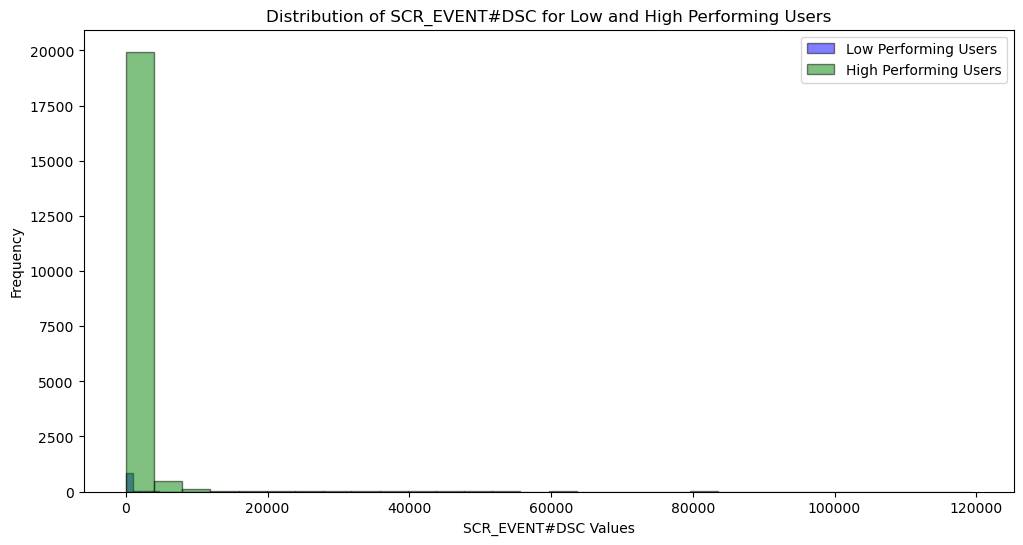

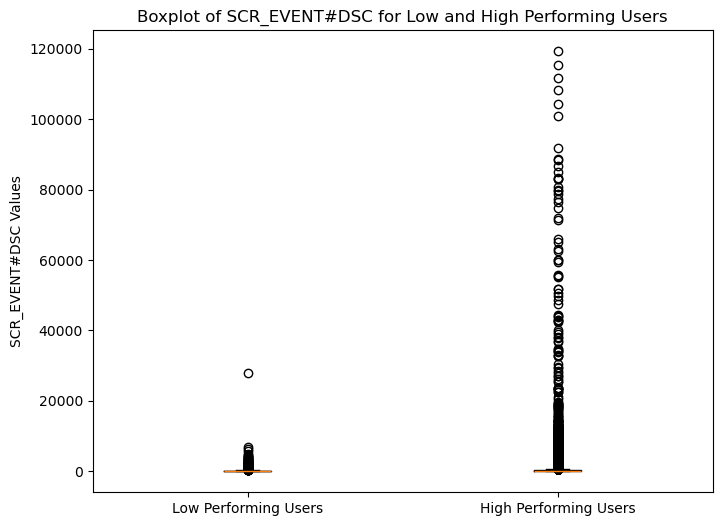

T-test results for SCR_EVENT#DSC: t-statistic = -8.978013212040885, p-value = 5.955415216188471e-19
Mann-Whitney U test results for SCR_EVENT#DSC: U-statistic = 8948716.5, p-value = 0.0011637092997400878
Pearson correlation for low-performing users: -0.029990958395963076
Pearson correlation for high-performing users: 0.03828407502435474


In [47]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'SCR_EVENT#DSC'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")

Descriptive Statistics for Low Performing Users:
Mean: 6.78223180770874, Median: 4.0, Std: 8.479867935180664, Min: 0.0, Max: 81.0

Descriptive Statistics for High Performing Users:
Mean: 11.147564888000488, Median: 4.0, Std: 78.5809097290039, Min: 0.0, Max: 3122.0


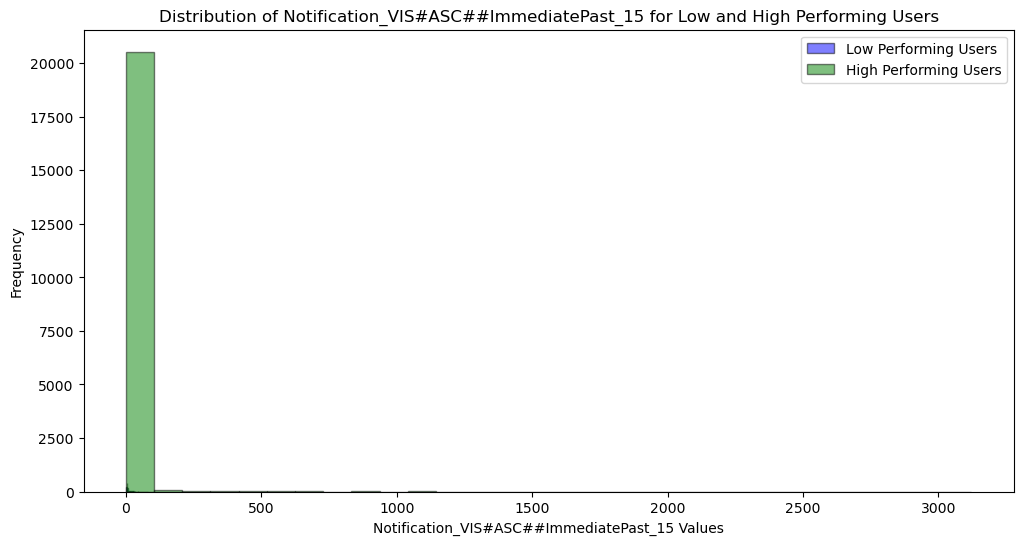

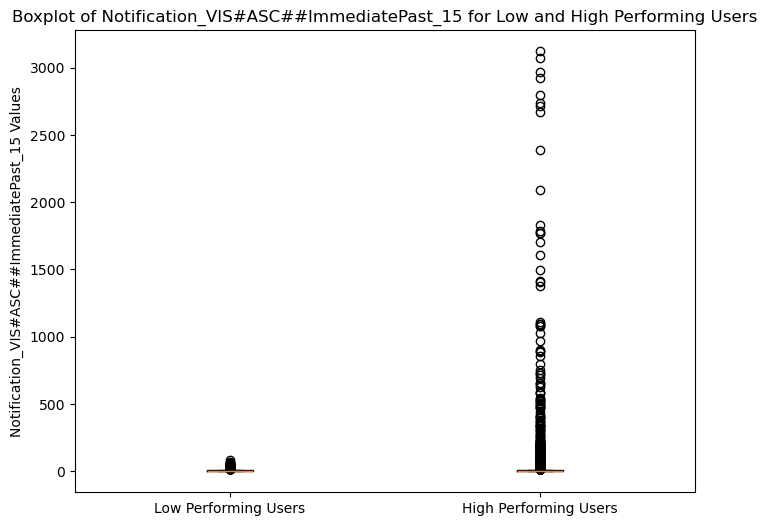

T-test results for Notification_VIS#ASC##ImmediatePast_15: t-statistic = -7.115189840514694, p-value = 1.1761759216430842e-12
Mann-Whitney U test results for Notification_VIS#ASC##ImmediatePast_15: U-statistic = 9145593.0, p-value = 0.0278337604005867
Pearson correlation for low-performing users: -0.061783587815402496
Pearson correlation for high-performing users: 0.010258681249692932


In [48]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Extract the feature for low and high performing users
feature_name = 'Notification_VIS#ASC##ImmediatePast_15'
low_feature_values = X_low[feature_name]
high_feature_values = X_high[feature_name]

# 1. Descriptive statistics
print("Descriptive Statistics for Low Performing Users:")
print(f"Mean: {np.mean(low_feature_values)}, Median: {np.median(low_feature_values)}, Std: {np.std(low_feature_values)}, Min: {np.min(low_feature_values)}, Max: {np.max(low_feature_values)}")

print("\nDescriptive Statistics for High Performing Users:")
print(f"Mean: {np.mean(high_feature_values)}, Median: {np.median(high_feature_values)}, Std: {np.std(high_feature_values)}, Min: {np.min(high_feature_values)}, Max: {np.max(high_feature_values)}")

# 2. Visualize the distributions
plt.figure(figsize=(12, 6))
plt.hist(low_feature_values, bins=30, alpha=0.5, label='Low Performing Users', color='blue', edgecolor='black')
plt.hist(high_feature_values, bins=30, alpha=0.5, label='High Performing Users', color='green', edgecolor='black')
plt.xlabel(f"{feature_name} Values")
plt.ylabel("Frequency")
plt.title(f"Distribution of {feature_name} for Low and High Performing Users")
plt.legend()
plt.show()

# Boxplot for better visualization
plt.figure(figsize=(8, 6))
plt.boxplot([low_feature_values, high_feature_values], labels=['Low Performing Users', 'High Performing Users'])
plt.title(f"Boxplot of {feature_name} for Low and High Performing Users")
plt.ylabel(f"{feature_name} Values")
plt.show()

# 3. Statistical test (T-test or Mann-Whitney U test based on normality)
# If data is normally distributed use t-test; otherwise, Mann-Whitney U test
t_stat, p_val = stats.ttest_ind(low_feature_values, high_feature_values, equal_var=False)
print(f"T-test results for {feature_name}: t-statistic = {t_stat}, p-value = {p_val}")

# Alternatively, if not normally distributed:
u_stat, p_val_u = stats.mannwhitneyu(low_feature_values, high_feature_values)
print(f"Mann-Whitney U test results for {feature_name}: U-statistic = {u_stat}, p-value = {p_val_u}")

# 4. Correlation with the target for each group
pearson_corr_low = np.corrcoef(low_feature_values, y_low)[0, 1]
pearson_corr_high = np.corrcoef(high_feature_values, y_high)[0, 1]
print(f"Pearson correlation for low-performing users: {pearson_corr_low}")
print(f"Pearson correlation for high-performing users: {pearson_corr_high}")